# 데이터 시각화 실습
## Jena 기후 데이터 시각화 실습 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt


### 1. 데이터 불러오기 & 저장  


In [3]:
# CSV 다운로드 및 샘플링
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
df = pd.read_csv(url, compression='zip')[5::6]  # 10분→1시간 단위 변환
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [4]:
# 서브셋 저장
df.iloc[:1000].to_csv('jena_sample.csv', index=False)  # 1,000행 샘플 저장

### 2. 윈도우 사이즈별 시각화 

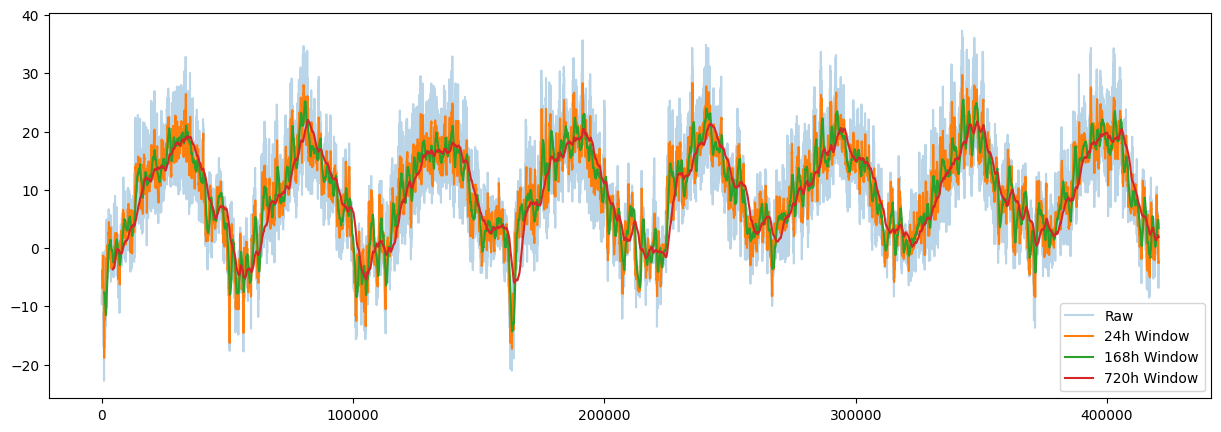

In [5]:
# 이동평균 비교
def plot_window(data, col='T (degC)', windows=[24, 168, 720]):
    plt.figure(figsize=(15,5))
    plt.plot(data[col], alpha=0.3, label='Raw')
    for win in windows:
        plt.plot(data[col].rolling(win).mean(), 
                label=f'{win}h Window')
    plt.legend()
    plt.show()

plot_window(df)  # 24h(일), 168h(주), 720h(월) 윈도우

 
### 3. 시계열 분해(추세/계절성/잔여)  


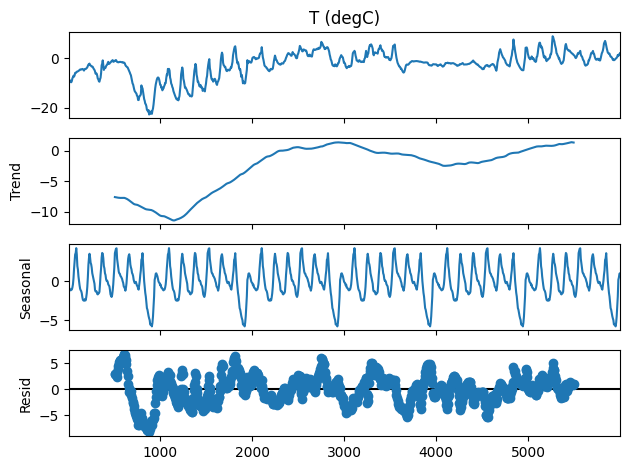

In [ ]:
# Statsmodels 활용
from statsmodels.tsa.seasonal import seasonal_decompose

def ts_decomposition(data, col='T (degC)', period=24*7):  # 주간 주기 가정
    result = seasonal_decompose(data[col], model='additive', period=period)
    result.plot()
    plt.show()

ts_decomposition(df.iloc[:1000])  # 1,000개 샘플로 분석

### 4. 이상치 탐지  


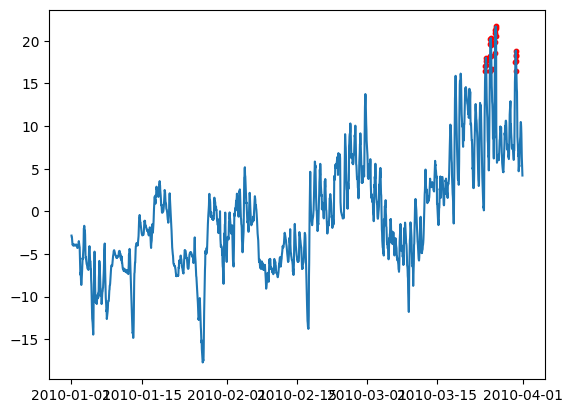

In [12]:
# IQR 기반 아웃라이어 식별
def detect_outliers(data, col='T (degC)'):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    plt.scatter(outliers.index, outliers[col], c='red', s=10)
    plt.plot(data[col])
    plt.show()

# Ensure the index is sorted
df = df.sort_index()

detect_outliers(df['2010-01':'2010-03'], col='T (degC)')  # 특정 구간 분석

### 5. 결측치 처리 옵션  

In [13]:
import numpy as np

# 다중 보간 기법
# 결측치 생성 테스트 (임의로 10% 삭제)
sample = df['T (degC)'].iloc[:1000].copy()
sample.loc[sample.sample(100).index] = np.nan

# 1. 전방 채우기
filled_ffill = sample.ffill()  

# 2. 선형 보간
filled_linear = sample.interpolate(method='linear')  

# 3. 계절성 고려 보간
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sample.ffill(), period=24)
filled_seasonal = result.seasonal + result.trend  # 계절성+추세 재조합

**시각화 Best Practice**  
1. **다중 플롯 활용**: `plt.subplots()`로 트렌드/계절성 병렬 표시  
2. **색상 팔레트**: `seaborn.color_palette("husl", 8)`로 구분력 향상  
3. **Interactive 탐색**: `plotly` 라이브러리로 확대/구간 선택 기능 추가  

